<a href="https://colab.research.google.com/github/LatifulJoy/covid19-cnn-TL-mobilenet/blob/main/code_for_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os 
import pathlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D,SeparableConv2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"latifuljoy","key":"c9493e600d8dfc76ec7a58ea29031a33"}'}

In [3]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [4]:
!kaggle datasets download -d latifuljoy/covid-chest-xray-image-dataset

 98% 473M/484M [00:04<00:00, 134MB/s]
100% 484M/484M [00:04<00:00, 107MB/s]


In [5]:
!unzip \*.zip

Archive:  covid-chest-xray-image-dataset.zip
  inflating: COVID_IEEE/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg  
  inflating: COVID_IEEE/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg  
  inflating: COVID_IEEE/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b2.png 

In [61]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
import Augmentor

In [63]:
P = Augmentor.Pipeline('/content/COVID_IEEE', output_directory='/content/COVID_IEEE')

Initialised with 1493 image(s) found.
Output directory set to /content/COVID_IEEE.

In [64]:
P.rotate(probability=0.7, max_left_rotation =10, max_right_rotation=10)

In [65]:
P.zoom(probability  = 0.3, min_factor = 1.1, max_factor = 1.6)

In [66]:
P.sample(1493)

Processing <PIL.Image.Image image mode=L size=1396x1001 at 0x7FD10DDBF810>: 100%|██████████| 1493/1493 [02:46<00:00,  8.97 Samples/s]


In [67]:
for dirpath,dirnames,filenames in os.walk("/content/COVID_IEEE"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 3 directories and 0 images in '/content/COVID_IEEE'.
there are 0 directories and 1075 images in '/content/COVID_IEEE/virus'.
there are 0 directories and 964 images in '/content/COVID_IEEE/covid'.
there are 0 directories and 1062 images in '/content/COVID_IEEE/normal'.


In [68]:
import pathlib
import tensorflow as tf
data_dir = pathlib.Path("/content/COVID_IEEE")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['covid', 'normal', 'virus'], dtype='<U6')

In [69]:
img_height =224
img_width =224

In [76]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = 'training',
    seed =123,
    image_size = (img_height, img_width),
    batch_size =32
)

Found 2986 files belonging to 3 classes.
Using 2389 files for training.


In [77]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = 'validation',
    seed =123,
    image_size = (img_height, img_width),
    batch_size = 32
)

Found 2986 files belonging to 3 classes.
Using 597 files for validation.


In [78]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [81]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, label_batch= next(iter(normalized_ds))
first_image = image_batch[0]
#Notice the pixel values are now in (0,1)
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [82]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation_ds= validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [88]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [89]:
model = Sequential()

#Block Number 1
model.add(Conv2D(input_shape = (224,224,3), filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))


model.add(MaxPool2D((2,2)))


#Block Number 2
model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))


model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))
model.add(MaxPool2D((2,2)))
Dropout(0.20)

#Block Number 3
model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))
Dropout(0.20)

#Block Number 4
model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))

Dropout(0.40)


# Fully Connected layer
model.add(Flatten())

model.add(Dense(units=1024, activation="relu"))

model.add(Dense(units= 256, activation="relu"))
model.add(Dense(units=128, activation="relu"))
Dropout(0.40)

model.add(Dense(units=3, activation="softmax"))

In [90]:
model.compile(optimizer = opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [91]:
history1 = model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs=20
)

Epoch 1/20
75/75 [==============================] - 10s 123ms/step - loss: 0.7379 - accuracy: 0.6802 - val_loss: 0.4264 - val_accuracy: 0.8576
Epoch 2/20
75/75 [==============================] - 9s 122ms/step - loss: 0.4646 - accuracy: 0.8150 - val_loss: 0.3544 - val_accuracy: 0.8543
Epoch 3/20
75/75 [==============================] - 9s 123ms/step - loss: 0.2940 - accuracy: 0.8903 - val_loss: 0.3959 - val_accuracy: 0.8308
Epoch 4/20
75/75 [==============================] - 9s 124ms/step - loss: 0.2255 - accuracy: 0.9192 - val_loss: 0.1893 - val_accuracy: 0.9229
Epoch 5/20
75/75 [==============================] - 9s 125ms/step - loss: 0.2410 - accuracy: 0.9054 - val_loss: 0.1914 - val_accuracy: 0.9229
Epoch 6/20
75/75 [==============================] - 9s 125ms/step - loss: 0.1740 - accuracy: 0.9334 - val_loss: 0.3107 - val_accuracy: 0.8760
Epoch 7/20
75/75 [==============================] - 9s 125ms/step - loss: 0.1617 - accuracy: 0.9318 - val_loss: 0.2235 - val_accuracy: 0.9012
Epoch

Text(0.5, 1.0, 'Accuracy Curves')

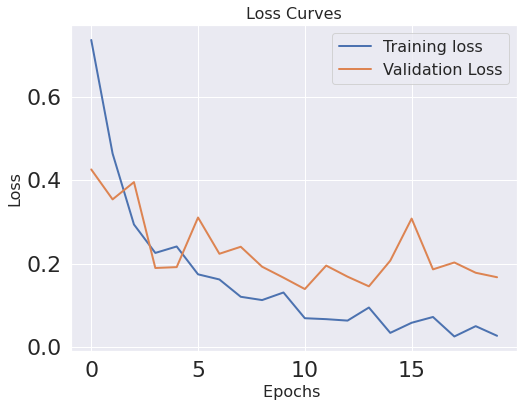

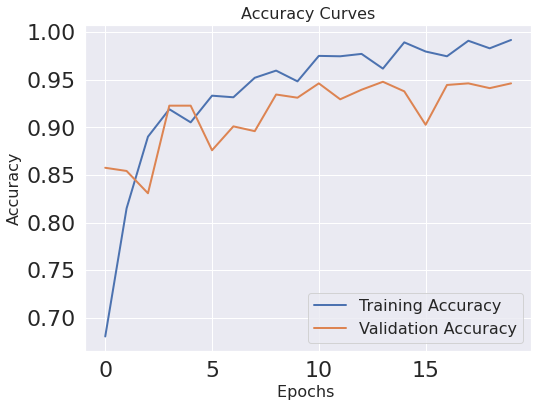

In [92]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['loss'],linewidth=2.0)
plt.plot(history1.history['val_loss'],linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['accuracy'],linewidth=2.0)
plt.plot(history1.history['val_accuracy'],linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [93]:
from tensorflow.keras.models import Model
a = np.array(history1.history['accuracy']).mean()
history1.history
model.evaluate_generator(generator=validation_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


[0.16702952980995178, 0.9463986754417419]

In [95]:
import seaborn as sns

In [96]:
train_label =np.concatenate([y for x, y in train_ds], axis = 0)
print(train_label.shape)

test_label =np.concatenate([y for x, y in validation_ds], axis = 0)
print(test_label.shape)

(2389,)
(597,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


Confusion Matrix
[[166   2   0]
 [  0 198  11]
 [  4  15 201]]


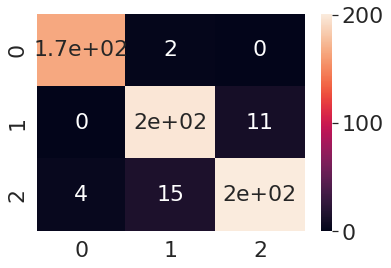

In [97]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
Y_pred = model.predict_generator(validation_ds, 1600)
y_pred = np.argmax(Y_pred, axis =1)
print("Confusion Matrix")
Cm = confusion_matrix(test_label,y_pred)
print(Cm)
sns.heatmap(Cm, annot = True, annot_kws={'size': 22})

In [98]:
print('Classification Report')
target_names=['covid', 'normal', 'virus']
print(classification_report(test_label, y_pred, target_names = target_names))

Classification Report
              precision    recall  f1-score   support

       covid       0.98      0.99      0.98       168
      normal       0.92      0.95      0.93       209
       virus       0.95      0.91      0.93       220

    accuracy                           0.95       597
   macro avg       0.95      0.95      0.95       597
weighted avg       0.95      0.95      0.95       597



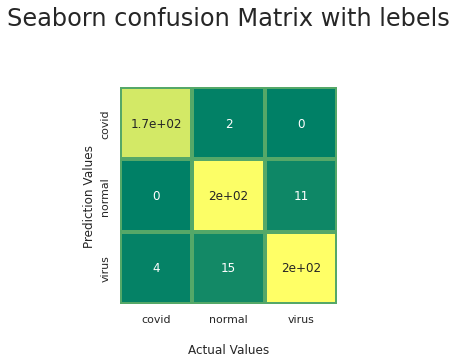

In [99]:
import seaborn as sns
sns.set(font_scale = 1.0)
ax = sns.heatmap(Cm, annot= True, cmap = 'summer', cbar = False, linewidths=3, linecolor='g', square = True, xticklabels =target_names, yticklabels= target_names, mask= False, ax = None)

sns.set(font_scale = 2.0)
ax.set_title('Seaborn confusion Matrix with lebels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel("Prediction Values");

In [100]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [101]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D,  GlobalAveragePooling2D
base_model = InceptionV3(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top = False)

#Freeze the first ten layers
for layer in base_model.layers[:10]:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(512, activation = 'relu')(x)
x= Dropout(0.4)(x)
predictions  = Dense(3, activation = 'softmax')(x)
model1 = Model(inputs = base_model.inputs, outputs = predictions)

In [102]:
model1.compile(optimizer =opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [103]:
history2 = model1.fit(
    train_ds,
    validation_data = validation_ds,
    epochs=20
)

Epoch 1/20
75/75 [==============================] - 27s 277ms/step - loss: 0.3531 - accuracy: 0.8610 - val_loss: 1.2807 - val_accuracy: 0.5796
Epoch 2/20
75/75 [==============================] - 17s 233ms/step - loss: 0.0730 - accuracy: 0.9736 - val_loss: 0.4434 - val_accuracy: 0.8559
Epoch 3/20
75/75 [==============================] - 18s 239ms/step - loss: 0.0207 - accuracy: 0.9941 - val_loss: 0.2286 - val_accuracy: 0.9397
Epoch 4/20
75/75 [==============================] - 18s 234ms/step - loss: 0.0181 - accuracy: 0.9950 - val_loss: 0.1633 - val_accuracy: 0.9581
Epoch 5/20
75/75 [==============================] - 17s 232ms/step - loss: 0.0210 - accuracy: 0.9929 - val_loss: 0.1360 - val_accuracy: 0.9715
Epoch 6/20
75/75 [==============================] - 17s 232ms/step - loss: 0.0206 - accuracy: 0.9925 - val_loss: 0.1657 - val_accuracy: 0.9481
Epoch 7/20
75/75 [==============================] - 18s 234ms/step - loss: 0.0647 - accuracy: 0.9824 - val_loss: 0.2872 - val_accuracy: 0.9464

Text(0.5, 1.0, 'Accuracy Curves')

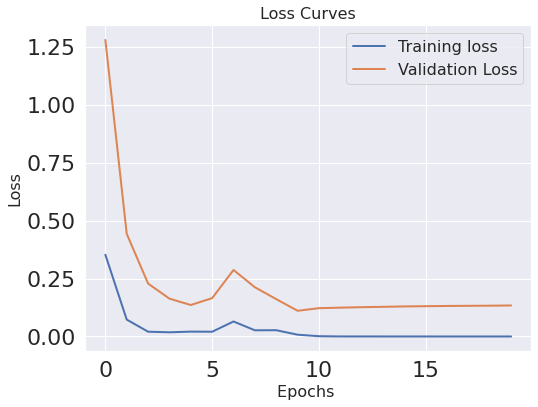

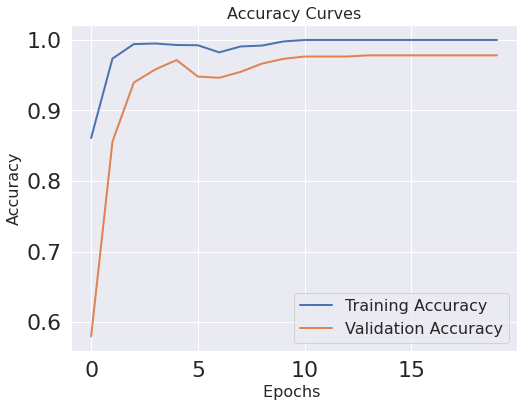

In [104]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history2.history['loss'],linewidth=2.0)
plt.plot(history2.history['val_loss'],linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history2.history['accuracy'],linewidth=2.0)
plt.plot(history2.history['val_accuracy'],linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


Confusion Matrix
[[167   0   1]
 [  0 203   6]
 [  1   5 214]]


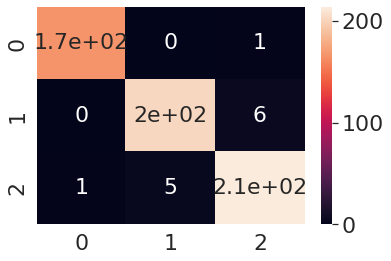

In [105]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
Y_pred = model1.predict_generator(validation_ds, 1600)
y_pred = np.argmax(Y_pred, axis =1)
print("Confusion Matrix")
Cm = confusion_matrix(test_label,y_pred)
print(Cm)
sns.heatmap(Cm, annot = True, annot_kws={'size': 22})

In [106]:
print('Classification Report')
target_names=['covid', 'normal', 'virus']
print(classification_report(test_label, y_pred, target_names = target_names))

Classification Report
              precision    recall  f1-score   support

       covid       0.99      0.99      0.99       168
      normal       0.98      0.97      0.97       209
       virus       0.97      0.97      0.97       220

    accuracy                           0.98       597
   macro avg       0.98      0.98      0.98       597
weighted avg       0.98      0.98      0.98       597



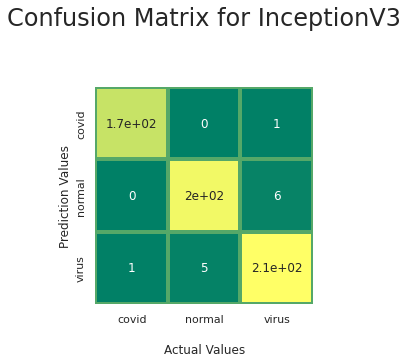

In [109]:
import seaborn as sns
sns.set(font_scale = 1.0)
ax = sns.heatmap(Cm, annot= True, cmap = 'summer', cbar = False, linewidths=3, linecolor='g', square = True, xticklabels =target_names, yticklabels= target_names, mask= False, ax = None)

sns.set(font_scale = 2.0)
ax.set_title('Confusion Matrix for InceptionV3\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel("Prediction Values");

In [110]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [111]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D,  GlobalAveragePooling2D
base_model = DenseNet121(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top = False)

#Freeze the first ten layers
for layer in base_model.layers[:10]:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(512, activation = 'relu')(x)
x= Dropout(0.4)(x)
predictions  = Dense(3, activation = 'softmax')(x)
model2 = Model(inputs = base_model.inputs, outputs = predictions)

In [112]:
model2.compile(optimizer =opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [113]:
history3 = model2.fit(
    train_ds,
    validation_data = validation_ds,
    epochs= 20
)

Epoch 1/20
75/75 [==============================] - 41s 415ms/step - loss: 0.2702 - accuracy: 0.9033 - val_loss: 0.5311 - val_accuracy: 0.7973
Epoch 2/20
75/75 [==============================] - 27s 357ms/step - loss: 0.0385 - accuracy: 0.9908 - val_loss: 0.2757 - val_accuracy: 0.9229
Epoch 3/20
75/75 [==============================] - 27s 365ms/step - loss: 0.0087 - accuracy: 0.9992 - val_loss: 0.1007 - val_accuracy: 0.9665
Epoch 4/20
75/75 [==============================] - 28s 367ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0859 - val_accuracy: 0.9782
Epoch 5/20
75/75 [==============================] - 27s 364ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0841 - val_accuracy: 0.9749
Epoch 6/20
75/75 [==============================] - 28s 371ms/step - loss: 5.7548e-04 - accuracy: 1.0000 - val_loss: 0.0871 - val_accuracy: 0.9765
Epoch 7/20
75/75 [==============================] - 27s 365ms/step - loss: 4.8450e-04 - accuracy: 1.0000 - val_loss: 0.0867 - val_accuracy

Text(0.5, 1.0, 'Accuracy Curves')

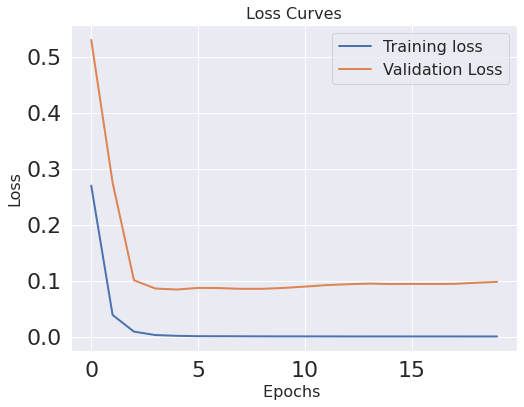

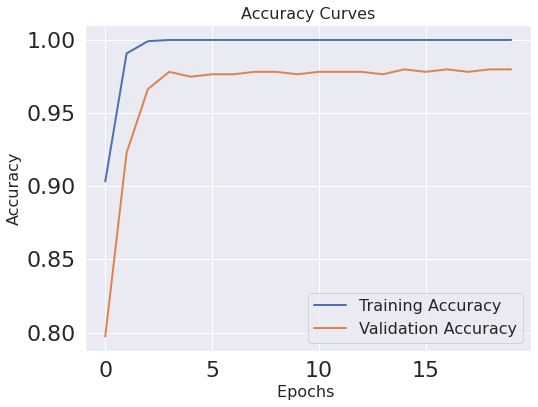

In [128]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history3.history['loss'],linewidth=2.0)
plt.plot(history3.history['val_loss'],linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history3.history['accuracy'],linewidth=2.0)
plt.plot(history3.history['val_accuracy'],linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


Confusion Matrix
[[168   0   0]
 [  0 204   5]
 [  1   6 213]]


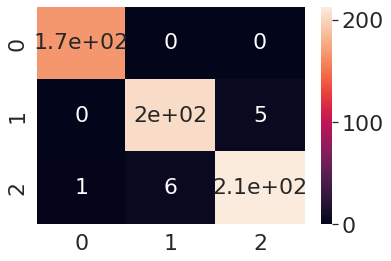

In [115]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
Y_pred = model2.predict_generator(validation_ds, 1600)
y_pred = np.argmax(Y_pred, axis =1)
print("Confusion Matrix")
Cm = confusion_matrix(test_label,y_pred)
print(Cm)
sns.heatmap(Cm, annot = True, annot_kws={'size': 22})

In [116]:
print('Classification Report')
target_names=['covid', 'normal', 'virus']
print(classification_report(test_label, y_pred, target_names = target_names))

Classification Report
              precision    recall  f1-score   support

       covid       0.99      1.00      1.00       168
      normal       0.97      0.98      0.97       209
       virus       0.98      0.97      0.97       220

    accuracy                           0.98       597
   macro avg       0.98      0.98      0.98       597
weighted avg       0.98      0.98      0.98       597



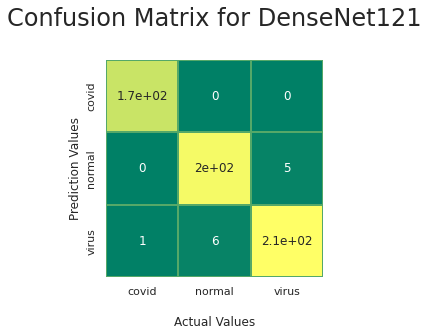

In [118]:
import seaborn as sns
sns.set(font_scale = 1.0)
ax = sns.heatmap(Cm, annot= True, cmap = 'summer', cbar = False, linewidths=1, linecolor='g', square = True, xticklabels =target_names, yticklabels= target_names, mask= False, ax = None)

sns.set(font_scale = 2.0)
ax.set_title('Confusion Matrix for DenseNet121\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel("Prediction Values");

In [119]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [120]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D,  GlobalAveragePooling2D
base_model = MobileNet(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top = False)

#Freeze the first ten layers
for layer in base_model.layers[:10]:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(512, activation = 'relu')(x)
x= Dropout(0.4)(x)
predictions  = Dense(3, activation = 'softmax')(x)
model3 = Model(inputs = base_model.inputs, outputs = predictions)

In [121]:
model3.compile(optimizer =opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [122]:
history4 = model3.fit(
    train_ds,
    validation_data = validation_ds,
    epochs= 20
)

Epoch 1/20
75/75 [==============================] - 13s 146ms/step - loss: 0.3889 - accuracy: 0.8481 - val_loss: 4.2246 - val_accuracy: 0.5209
Epoch 2/20
75/75 [==============================] - 10s 134ms/step - loss: 0.0700 - accuracy: 0.9803 - val_loss: 2.8613 - val_accuracy: 0.5444
Epoch 3/20
75/75 [==============================] - 10s 136ms/step - loss: 0.0183 - accuracy: 0.9958 - val_loss: 2.3193 - val_accuracy: 0.5578
Epoch 4/20
75/75 [==============================] - 10s 135ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.8217 - val_accuracy: 0.7722
Epoch 5/20
75/75 [==============================] - 10s 134ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.2366 - val_accuracy: 0.9246
Epoch 6/20
75/75 [==============================] - 10s 133ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.1541 - val_accuracy: 0.9514
Epoch 7/20
75/75 [==============================] - 10s 133ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1386 - val_accuracy: 0.9531

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


Confusion Matrix
[[166   1   1]
 [  0 202   7]
 [  4   6 210]]


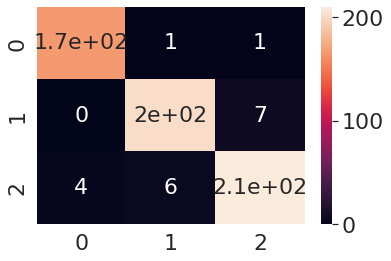

In [123]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
Y_pred = model3.predict_generator(validation_ds, 1600)
y_pred = np.argmax(Y_pred, axis =1)
print("Confusion Matrix")
Cm = confusion_matrix(test_label,y_pred)
print(Cm)
sns.heatmap(Cm, annot = True, annot_kws={'size': 22})

In [124]:
print('Classification Report')
target_names=['covid', 'normal', 'virus']
print(classification_report(test_label, y_pred, target_names = target_names))

Classification Report
              precision    recall  f1-score   support

       covid       0.98      0.99      0.98       168
      normal       0.97      0.97      0.97       209
       virus       0.96      0.95      0.96       220

    accuracy                           0.97       597
   macro avg       0.97      0.97      0.97       597
weighted avg       0.97      0.97      0.97       597



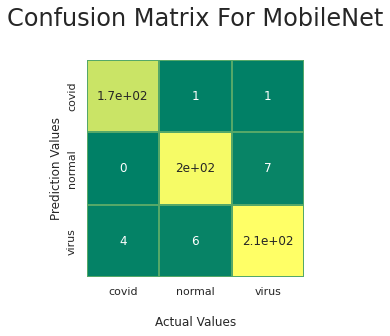

In [126]:
import seaborn as sns
sns.set(font_scale = 1.0)
ax = sns.heatmap(Cm, annot= True, cmap = 'summer', cbar = False, linewidths=1, linecolor='g', square = True, xticklabels =target_names, yticklabels= target_names, mask= False, ax = None)

sns.set(font_scale = 2.0)
ax.set_title('Confusion Matrix For MobileNet\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel("Prediction Values");

Text(0.5, 1.0, 'Accuracy Curves')

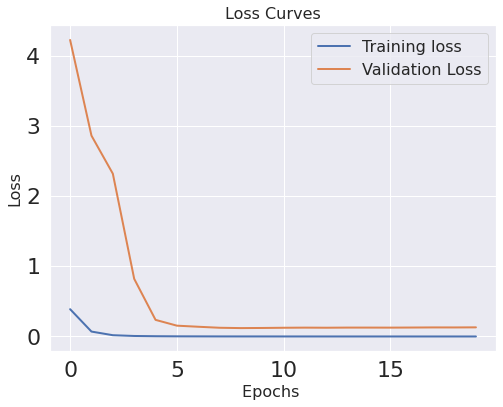

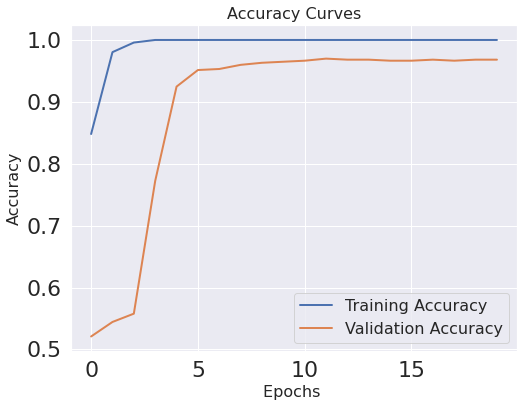

In [127]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history4.history['loss'],linewidth=2.0)
plt.plot(history4.history['val_loss'],linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history4.history['accuracy'],linewidth=2.0)
plt.plot(history4.history['val_accuracy'],linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)